# Mask R-CNN - Shapesデータセットでの学習


このノートブックは、独自のデータセットでMask R-CNNを学習する方法を示します。シンプルに保つため、高速な学習が可能な図形（四角形、三角形、円）の合成データセットを使用します。ただし、ネットワークのバックボーンがResnet101であるため、GPUが必要です。CPUでは学習が遅すぎます。GPUを使用すれば、数分でまずまずの結果が得られ、1時間未満で良い結果が得られます。

*Shapes*データセットのコードは以下に含まれています。画像を動的に生成するため、データのダウンロードは不要です。また、任意のサイズの画像を生成できるため、より高速に学習できるよう小さい画像サイズを選択しています。

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## 設定

In [ ]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 shapes (square, circle, triangle, star)

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()

## ノートブックの設定

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## データセット

合成データセットを作成

Datasetクラスを拡張し、shapesデータセットを読み込むメソッド`load_shapes()`を追加し、以下のメソッドをオーバーライドします：

* load_image()
* load_mask()
* image_reference()

In [ ]:
# ShapesDatasetクラス: 図形の合成データセットを生成するクラス
# utils.Datasetを継承して、Mask R-CNN用のデータローダーを実装
class ShapesDataset(utils.Dataset):
    """図形の合成データセットを生成します。このデータセットは、
    空白の背景上にランダムに配置されたシンプルな図形（三角形、四角形、円）
    で構成されています。画像は動的に生成されるため、ファイルアクセスは不要です。
    """

    # 指定された数の合成画像を生成してデータセットに追加
    def load_shapes(self, count, height, width):
        """指定された数の合成画像を生成します。
        count: 生成する画像の数
        height, width: 生成する画像のサイズ
        """
        # クラス（物体カテゴリ）を追加
        self.add_class("shapes", 1, "square")  # 四角形クラス（ID: 1）
        self.add_class("shapes", 2, "circle")  # 円形クラス（ID: 2）
        self.add_class("shapes", 3, "triangle")  # 三角形クラス（ID: 3）
        self.add_class("shapes", 4, "star")  # 星形クラス（ID: 4）

        # 画像を追加
        # 実際の画像ではなく、画像の仕様（色、図形のサイズと位置）をランダムに生成
        # 画像は load_image() で動的に生成される
        for i in range(count):
            # 背景色と図形のリストをランダムに生成
            bg_color, shapes = self.random_image(height, width)
            # データセットに画像情報を追加（実際の画像ではなくメタデータ）
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    # 指定されたIDの画像を生成して返す
    def load_image(self, image_id):
        """指定された画像IDの仕様から画像を生成します。
        通常この関数はファイルから画像を読み込みますが、
        このケースでは image_info の仕様から動的に画像を生成します。
        """
        # 画像情報を取得
        info = self.image_info[image_id]
        # 背景色を3チャンネルの配列に変換
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        # 指定サイズの画像を作成（初期値は1）
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        # 背景色で塗りつぶし
        image = image * bg_color.astype(np.uint8)
        # 各図形を画像に描画
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    # 画像の参照情報を返す（デバッグ用）
    def image_reference(self, image_id):
        """画像の図形データを返します。"""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            # 親クラスのメソッドを呼び出し
            super(self.__class__).image_reference(self, image_id)

    # 指定されたIDの画像に対するインスタンスマスクを生成
    def load_mask(self, image_id):
        """指定された画像IDの図形に対するインスタンスマスクを生成します。
        """
        # 画像情報を取得
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)  # 図形の数
        # 各図形のマスクを格納する3次元配列を初期化（高さ×幅×図形数）
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        # 各図形のマスクを生成
        for i, (shape, _, dims) in enumerate(info['shapes']):
            # i番目の図形のマスクを描画（値は1）
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # オクルージョン（重なり）の処理
        # 最後の図形が見えない部分を計算
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        # 後ろから前に向かって、重なっている部分を除去
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            # 次のオクルージョンマスクを更新
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # クラス名をクラスIDに変換
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        # マスク（bool型）とクラスID（int32型）を返す
        # NumPy 1.20以降の互換性のため、np.boolではなくboolを使用
        return mask.astype(bool), class_ids.astype(np.int32)

    # 指定された図形を画像に描画
    def draw_shape(self, image, shape, dims, color, show_image=False):
        """指定された仕様から図形を描画します。
        show_image: Trueの場合、描画後の画像を表示
        """
        # 中心座標(x, y)とサイズsを取得
        x, y, s = dims
        if shape == 'square':
            # 四角形を描画（左上と右下の座標を指定、-1で塗りつぶし）
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
            print(f"描画: 四角形 - 中心({x}, {y}), サイズ{s}, 色{color}")
        elif shape == "circle":
            # 円を描画（中心座標と半径を指定、-1で塗りつぶし）
            cv2.circle(image, (x, y), s, color, -1)
            print(f"描画: 円 - 中心({x}, {y}), 半径{s}, 色{color}")
        elif shape == "triangle":
            # 三角形の頂点を計算（正三角形）
            points = np.array([[(x, y-s),  # 上の頂点
                                (x-s/math.sin(math.radians(60)), y+s),  # 左下の頂点
                                (x+s/math.sin(math.radians(60)), y+s),  # 右下の頂点
                                ]], dtype=np.int32)
            # 多角形を塗りつぶし描画
            cv2.fillPoly(image, points, color)
            print(f"描画: 三角形 - 中心({x}, {y}), サイズ{s}, 色{color}")
            print(f"  頂点座標: {points[0].tolist()}")
        elif shape == "star":
            # 五芒星の頂点を計算
            points = []
            num_points = 5  # 五芒星
            # 外側の頂点と内側の頂点を交互に配置
            for i in range(num_points * 2):
                angle = math.pi * i / num_points - math.pi / 2  # 上から開始
                if i % 2 == 0:
                    # 外側の頂点（大きい半径）
                    radius = s
                else:
                    # 内側の頂点（小さい半径）
                    radius = s * 0.4  # 内側は外側の40%の大きさ
                px = int(x + radius * math.cos(angle))
                py = int(y + radius * math.sin(angle))
                points.append([px, py])
            points = np.array([points], dtype=np.int32)
            # 多角形を塗りつぶし描画
            cv2.fillPoly(image, points, color)
            print(f"描画: 星形 - 中心({x}, {y}), サイズ{s}, 色{color}")
            print(f"  頂点座標: {points[0].tolist()}")
        
        # 描画した画像を表示（オプション）
        if show_image:
            # OpenCVはBGR形式なので、表示用にRGBに変換
            if len(image.shape) == 3 and image.shape[2] == 3:
                # カラー画像の場合
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else:
                # グレースケールまたはマスク画像の場合
                image_rgb = image
            
            plt.figure(figsize=(6, 6))
            plt.imshow(image_rgb, cmap='gray' if len(image.shape) == 2 else None)
            plt.title(f"描画した図形: {shape}")
            plt.axis('off')
            plt.show()
        
        return image

    # ランダムな図形の仕様を生成
    def random_shape(self, height, width):
        """指定された高さと幅の境界内に収まるランダムな図形の仕様を生成します。
        以下の3つの値のタプルを返します：
        * 図形の名前（square, circle, ...）
        * 図形の色：RGB値の3つのタプル
        * 図形の寸法：図形のサイズと位置を定義する値のタプル
                     （図形の種類によって異なります）
        """
        # 図形の種類をランダムに選択（星形を追加）
        shape = random.choice(["square", "circle", "triangle", "star"])
        # RGB値をランダムに生成（0-255）
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # 中心座標をランダムに設定（画像の端から buffer ピクセル離れた範囲内）
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # サイズをランダムに設定（buffer から 画像高さの1/4 まで）
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    # 複数の図形を含む画像の仕様をランダムに生成
    def random_image(self, height, width):
        """複数の図形を含む画像のランダムな仕様を作成します。
        画像の背景色と、画像を描画するために使用できる
        図形仕様のリストを返します。
        """
        # 背景色をランダムに選択（RGB）
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # いくつかのランダムな図形を生成し、バウンディングボックスを記録
        shapes = []
        boxes = []
        N = random.randint(1, 4)  # 1〜4個の図形をランダムに配置
        for _ in range(N):
            # ランダムな図形を生成
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            # バウンディングボックスを計算（y1, x1, y2, x2）
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # 図形同士の重なりを避けるため、Non-Max Suppressionを適用（閾値0.3）
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        # 選択された図形のみを保持
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [ ]:
# テスト: 各図形を個別に描画して表示
test_dataset = ShapesDataset()

# テスト用の画像サイズ
test_size = 128

# 各図形を描画してテスト
# shapes_to_test = ["square", "circle", "triangle", "star"]
shapes_to_test = ["star"]
for shape_name in shapes_to_test:
    # 白背景の画像を作成
    test_image = np.ones((test_size, test_size, 3), dtype=np.uint8) * 255
    
    # 図形のパラメータを設定
    center_x, center_y = test_size // 2, test_size // 2
    size = test_size // 4
    color = (0, 255, 0)  # 赤色
    
    # 図形を描画して表示
    print(f"\n=== {shape_name.upper()} のテスト ===")
    test_dataset.draw_shape(test_image, shape_name, (center_x, center_y, size), color, show_image=True)

In [ ]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## モデルの作成

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## 学習

2段階で学習します：
1. ヘッド部分のみ。ここでは、すべてのバックボーン層を固定し、ランダムに初期化された層（つまり、MS COCOからの事前学習済み重みを使用しなかった層）のみを学習します。ヘッド層のみを学習するには、`train()`関数に`layers='heads'`を渡します。

2. すべての層をファインチューニング。この簡単な例では必要ありませんが、プロセスを示すために含めています。すべての層を学習するには、単に`layers="all"`を渡します。

In [8]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.002

Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 73s - loss: 2.2164 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 1.0638 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3006 - mrcnn_mask_loss: 0.2385 - val_loss: 1.8454 - val_rpn_class_loss: 0.0232 - val_rpn_bbox_loss: 0.9971 - val_mrcnn_class_loss: 0.1398 - val_mrcnn_bbox_loss: 0.1343 - val_mrcnn_mask_loss: 0.2042


In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## 検出

In [11]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

original_image           shape: (128, 128, 3)         min:  108.00000  max:  236.00000
image_meta               shape: (12,)                 min:    0.00000  max:  128.00000
gt_bbox                  shape: (2, 5)                min:    2.00000  max:  102.00000
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000


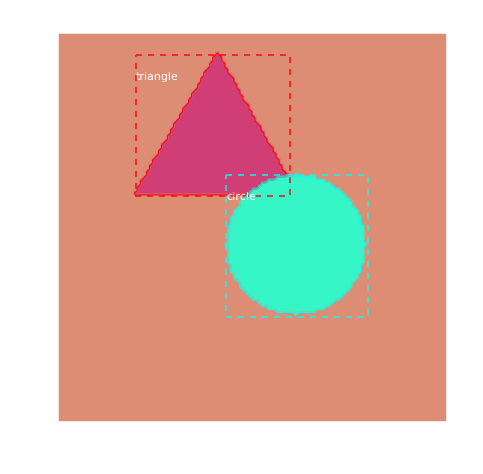

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


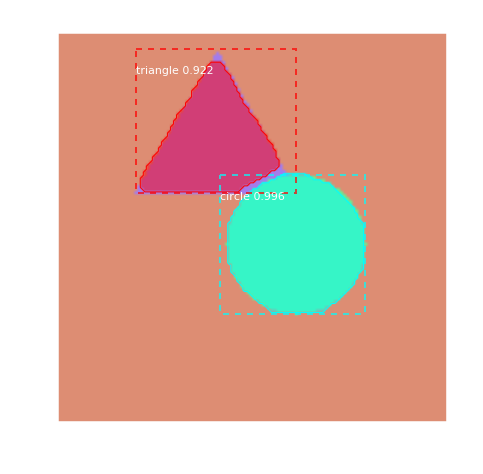

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## 評価

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
